Author: Daniel Lusk, University of Potsdam

Inspired by: Ankit Kariryaa ([github repo](https://github.com/ankitkariryaa/An-unexpectedly-large-count-of-trees-in-the-western-Sahara-and-Sahel))

In [1]:
import glob
import os
import time
import warnings
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import tensorflow as tf
from IPython.core.interactiveshell import InteractiveShell
from config import UNetTraining
from core.dataset_generator import DataGenerator
from core.frame_info import FrameInfo
from core.split_frames import split_dataset
from core.UNet import UNet
from core.visualize import display_images
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings("ignore")  # ignore annoying warnings

SHOW_PLOTS = True
TRAIN_MODEL = False
EXPLORE_PREDICTIONS = True
NOTEBOOK = True

if NOTEBOOK:
    # Magic commands
    %matplotlib inline
    %reload_ext autoreload
    %autoreload 2

    InteractiveShell.ast_node_interactivity = "all"

2023-02-08 09:22:34.327141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 09:22:34.894384: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/miniconda/envs/lusk_dap05/lib/:/opt/miniconda/envs/lusk_dap05/lib/:/opt/miniconda/envs/berlin-trees/lib/
2023-02-08 09:22:34.894440: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/miniconda/env

Load the configuration and get the image directories.

In [2]:
config = UNetTraining.Config()
im_dirs = glob.glob(os.path.join(config.image_dir, "*"))

Read all images (aka frames) into memory

In [3]:
frames = []

for d in tqdm(im_dirs):
    rgbi_im = rio.open(glob.glob(os.path.join(d, config.rgbi_dn, "*.tif"))[0])
    ndvi_im = rio.open(glob.glob(os.path.join(d, config.ndvi_dn, "*.tif"))[0])
    label_im = rio.open(glob.glob(os.path.join(d, config.label_dn, "*.tif"))[0])
    weights_im = rio.open(glob.glob(os.path.join(d, config.weights_dn, "*.tif"))[0])
    
    read_rgbi_im = (np.moveaxis(rgbi_im.read(), 0, -1)) / 255  # Scale to 0-1
    read_ndvi_im = (np.moveaxis(ndvi_im.read(), 0, -1) + 1) / 2  # Scale to 0-1
    read_label_im = np.moveaxis(label_im.read(), 0, -1)
    read_weights_im = np.moveaxis(weights_im.read(), 0, -1)
    
    if config.use_binary_labels:
        read_label_im[read_label_im > 0] = 1 # Binarize labels
    
    comb_im = np.dstack((read_rgbi_im, read_ndvi_im))
    f = FrameInfo(comb_im, read_label_im, read_weights_im, d)
    frames.append(f)

  0%|          | 0/360 [00:00<?, ?it/s]

Split into train, validation, and test sets, and initialize generators for each set.

In [4]:
train_frame_idx, val_frame_idx, test_frame_idx = split_dataset(
    frames,
    config.frames_json,
    config.patch_dir,
    test_override=config.test_override,
    val_override=config.val_override,
)

annotation_channels = config.input_label_channel + config.input_weight_channel

# Training data generator
# Don't apply augmentation for now until the weighting scheme overwriting is figured out.
train_generator = DataGenerator(
    config.input_image_channels,
    config.patch_size,
    train_frame_idx,
    frames,
    annotation_channels,
    wt_thr=config.weight_threshold,
    no_weights=config.no_weights
).random_generator(config.BATCH_SIZE)

# Validation data generator
val_generator = DataGenerator(
    config.input_image_channels,
    config.patch_size,
    val_frame_idx,
    frames,
    annotation_channels,
    wt_thr=config.weight_threshold,
    no_weights=config.no_weights
).random_generator(config.BATCH_SIZE)

# Testing data generator
test_generator = DataGenerator(
    config.input_image_channels,
    config.patch_size,
    test_frame_idx,
    frames,
    annotation_channels,
    wt_thr=config.weight_threshold,
    no_weights=config.no_weights
).random_generator(config.BATCH_SIZE)

Reading train-test split from file (hand_as_val_all_eroded_labels.json)

Using test override: ['393_5823']

Using val override: ['393_5823']

Training set size: 324
Validation set size: 36
Testing set size: 36


Inspect the images to ensure their labels and weights correspond accurately

(16, 256, 256, 7)


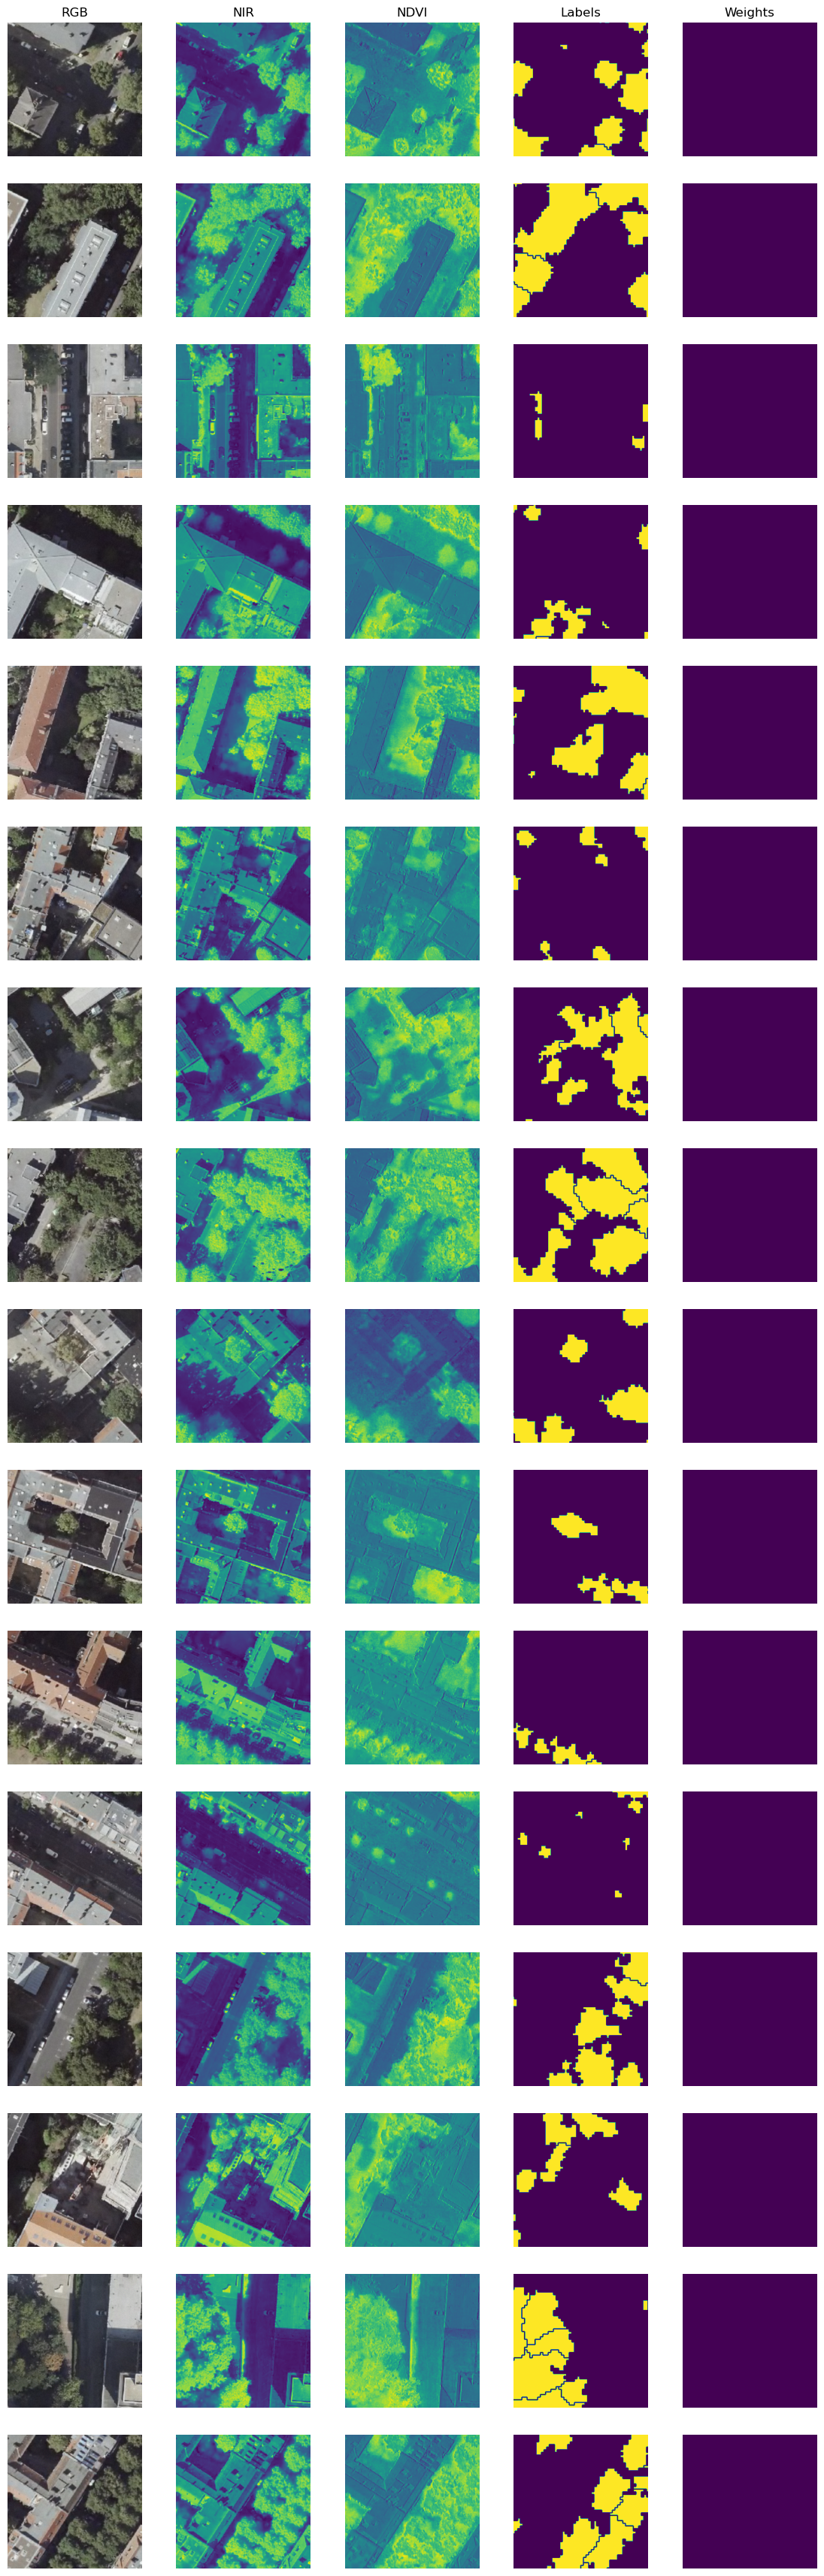

In [5]:
if SHOW_PLOTS:
    titles = ["RGB", "NIR", "NDVI", "Labels", "Weights"]

    train_images, real_label = next(train_generator)
    display_images(
        np.concatenate((train_images, real_label), axis=-1),
        config.input_image_channels,
        annotation_channels,
        titles,
    )

Define the model and compile it

In [6]:
model = UNet([config.BATCH_SIZE, *config.input_shape], config.input_label_channel)
model.compile(optimizer=config.optimizer, loss=config.loss, metrics=config.metrics)

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  2944        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                              

Train the model

In [ ]:
if TRAIN_MODEL:
    loss_history = [
        model.fit(
            train_generator,
            steps_per_epoch=config.MAX_TRAIN_STEPS,
            epochs=config.EPOCHS,
            validation_data=val_generator,
            validation_steps=config.VAL_LIMIT,
            callbacks=config.callbacks,
            workers=1
        )
    ]

Load the model and test

In [7]:
if EXPLORE_PREDICTIONS:
    # Load model after training
    # If you load a model with different python version, than you may run into a problem: https://github.com/keras-team/keras/issues/9595#issue-303471777
    
    model_fn = "./saved_models/UNet/20230204-1515_AdaDelta_weightmap_tversky_eroded_no-weights-all1_01234_256.h5"
    model = tf.keras.models.load_model(
        model_fn,
        custom_objects={
            "tversky": config.loss,
            "dice_coef": config.metrics[0],
            "dice_loss": config.metrics[1],
            "accuracy": config.metrics[4],
            "specificity": config.metrics[2],
            "sensitivity": config.metrics[3],
        },
        compile=False,
    )

    # In case you want to use multiple GPU you can uncomment the following lines.
    # from tensorflow.python.keras.utils import multi_gpu_model
    # model = multi_gpu_model(model, gpus=2, cpu_merge=False)

    model.compile(
        optimizer=config.optimizer,
        loss=config.loss,
        metrics=config.metrics,
    )

In [ ]:
if SHOW_PLOTS:
    # Print one batch on the training/test data!

    titles = ["RGB", "NDVI", "Labels", "Weights", "Prediction", "Predictions/Weights Overlay"]
    for i in range(1):
        test_images, real_label = next(test_generator)
        # 5 images per row: RGB, label, weight, prediction + weight overlay
        prediction = model.predict(test_images, steps=1)
        # prediction[prediction > 0.5] = 1
        # prediction[prediction <= 0.5] = 0

        weights = np.expand_dims(real_label[..., 1].copy(), -1)
        labels = np.expand_dims(real_label[..., 0].copy(), -1)
        weights[weights > 2] = 10 # boundaries
        weights[weights <= 2] = 0 # background
        # weights[weights == 1] = 3  # background
        # weights[weights == 0] = 1  # labels
        prediction[prediction >= 0.5] = 1  # predictions
        prediction[prediction < 0.5] =  0  # background
        # overlay = weights + (prediction * 15)
        overlay = weights + prediction + labels
        overlay[labels == 1] = 1
        overlay[prediction == 1] = 3
        overlay[weights == 10] = 5
        overlay[(labels == 0) & (prediction == 0) & (weights == 0)] = np.nan
        # overlay[overlay == 1] = np.nan

        display_images(
            np.concatenate((test_images[..., [0, 1, 2, 4]], real_label, prediction, overlay), axis=-1),
            config.input_image_channels,
            annotation_channels,
            titles=titles
        )

2023-02-08 09:23:38.517852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-08 09:23:38.867031: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


TP: tf.Tensor(5624.0, shape=(), dtype=float64)
FP: tf.Tensor(2595.0, shape=(), dtype=float64)
FN: tf.Tensor(2463.6000000000004, shape=(), dtype=float64)
Score: tf.Tensor(0.5264635945121379, shape=(), dtype=float64)


Text(0.5, 1.0, 'Labels')

(-0.5, 255.5, 255.5, -0.5)

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'Weights')

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'Pred')

Text(0.5, 1.0, 'TP: 5624.00')

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'FP: 2595.00')

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'FN: 2463.60')

(-0.5, 255.5, 255.5, -0.5)

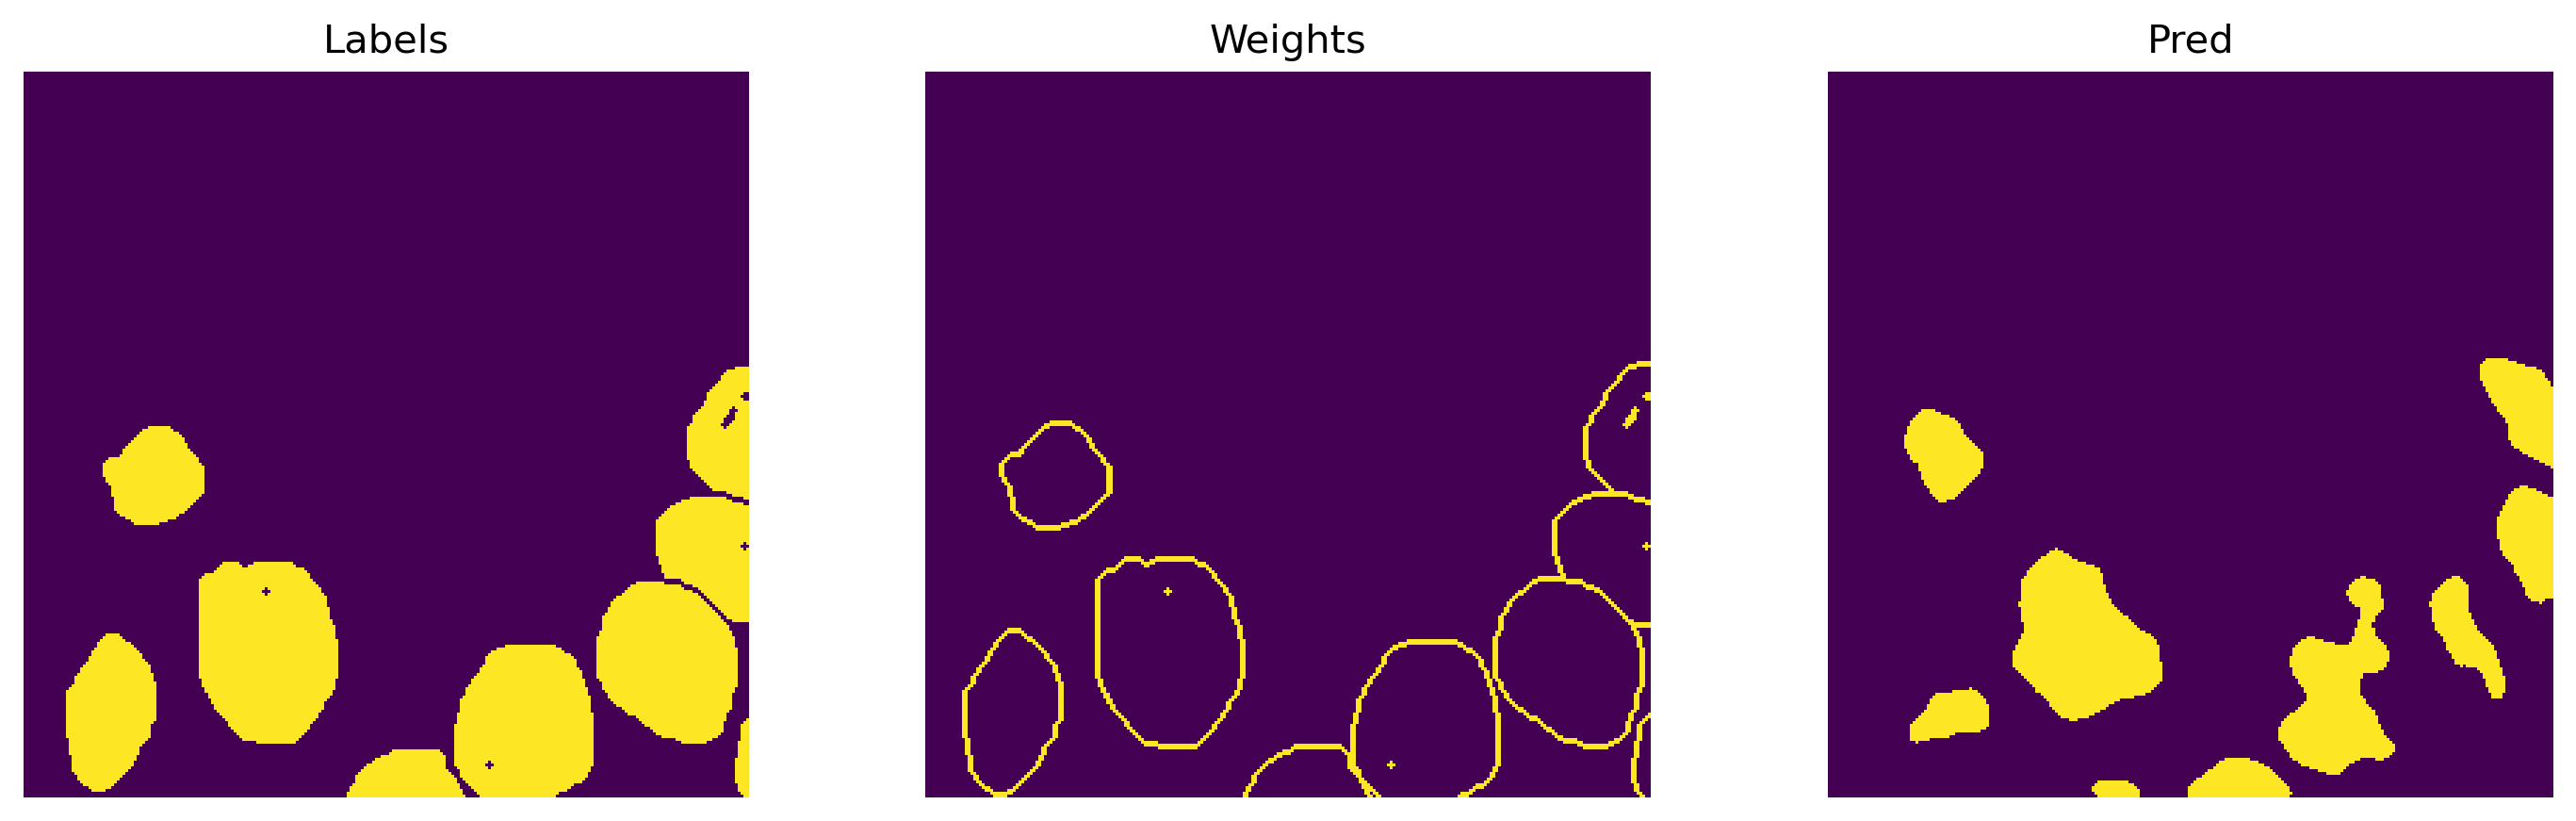

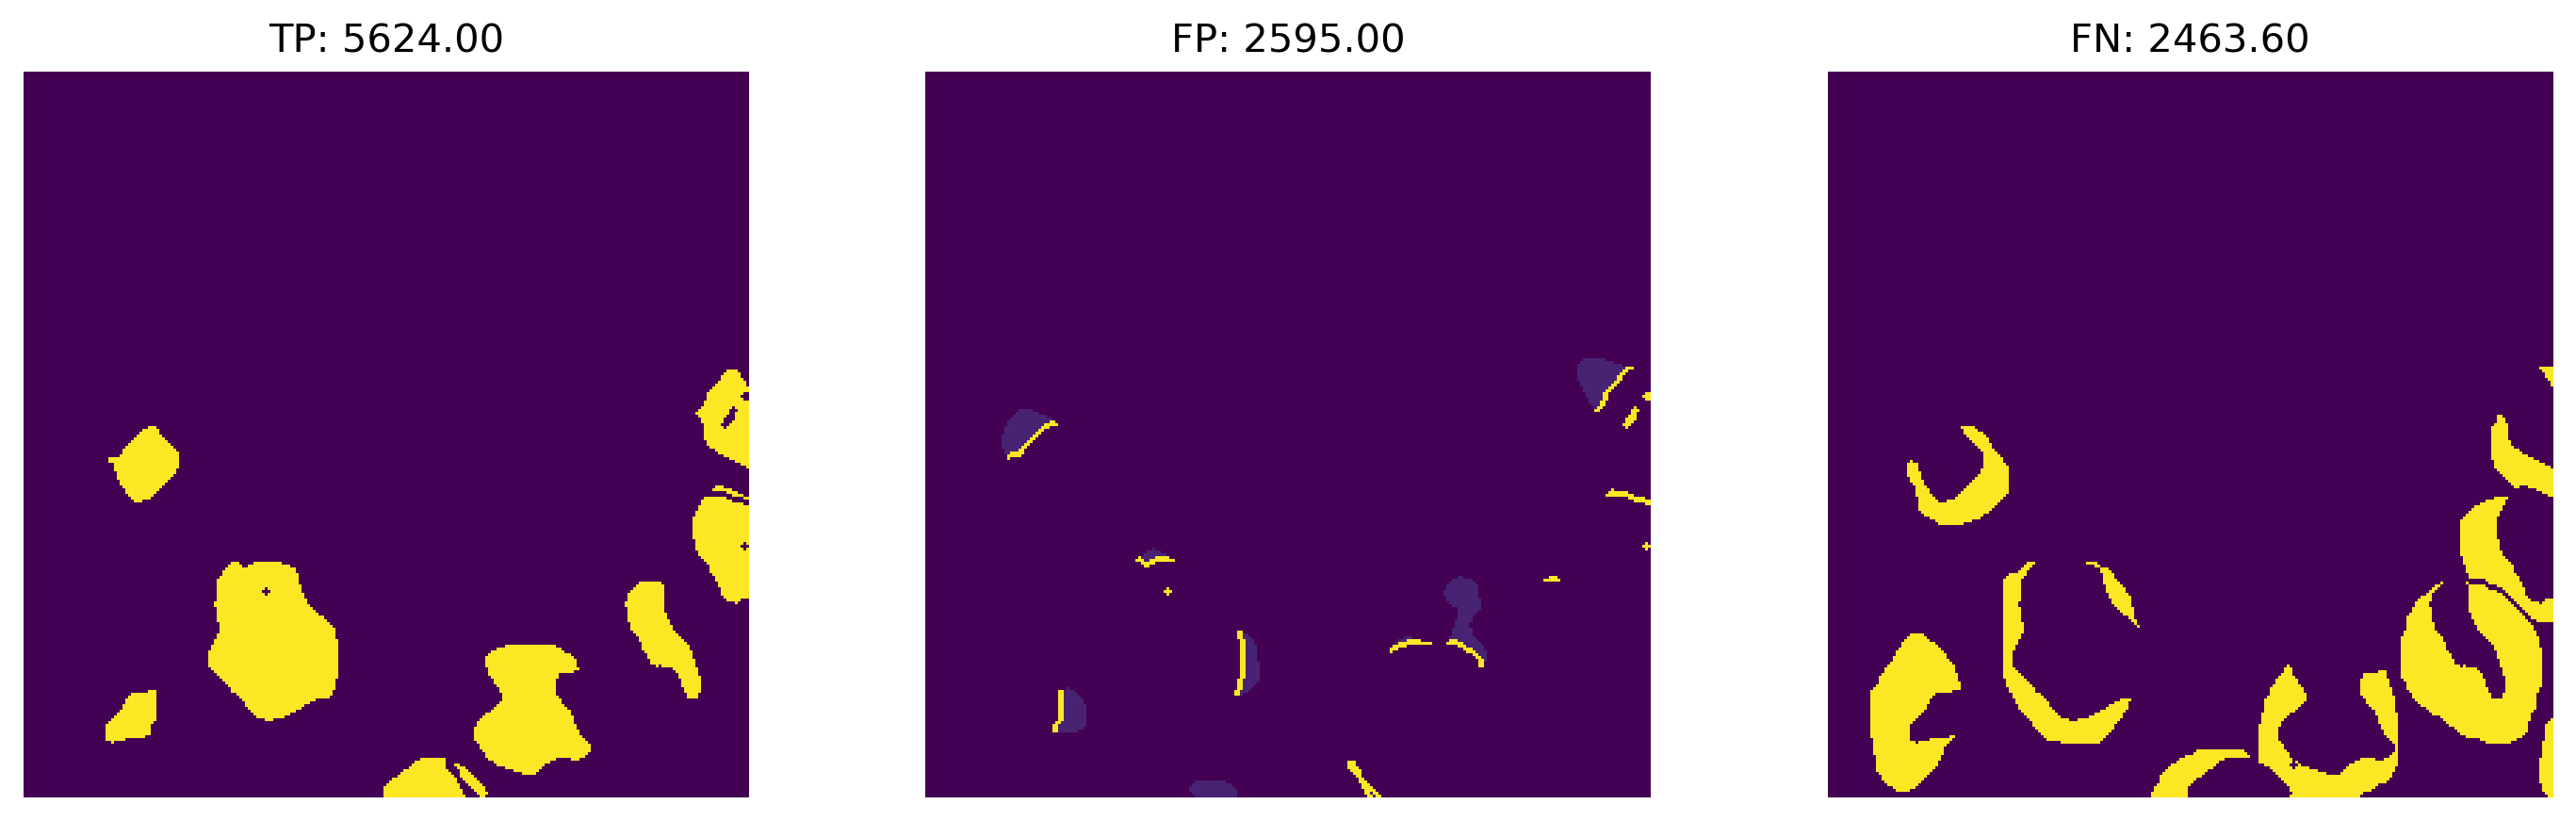

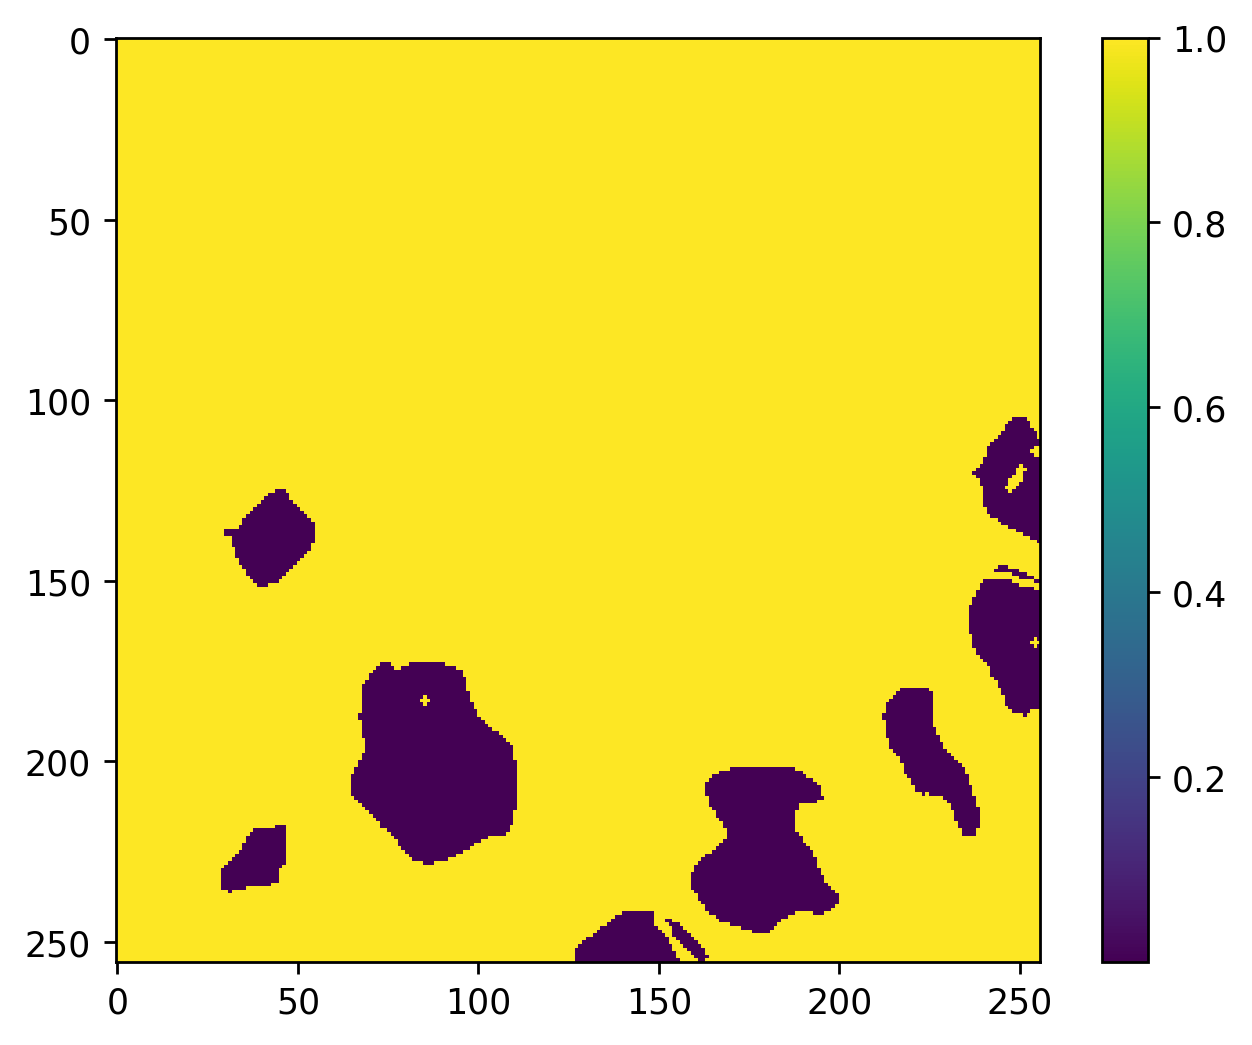

In [ ]:
if SHOW_PLOTS:
    y_pred = prediction[0]
    y_t = tf.expand_dims(real_label[0][..., 0].copy(), -1)
    y_weights = tf.expand_dims(real_label[0][..., 1].copy(), -1)
    alpha = 0.6
    beta = 0.4

    #### Override weight values to explore effect on losses
    y_weights = y_weights.numpy()
    y_weights[y_weights >= 2] = 10
    y_weights[y_weights < 2] = 1
    y_weights = tf.convert_to_tensor(y_weights)

    ones = 1
    p0 = y_pred  # Probability that pixels are class i
    p1 = ones - y_pred  # Probability that pixels are not class i
    g0 = y_t  # Ground truth
    g1 = ones - y_t

    tp_mat = (y_weights * p0 * g0).numpy()
    tp = tf.reduce_sum(y_weights * p0 * g0)
    fp_mat = (alpha * y_weights * p0 * g1).numpy()
    fp = alpha * tf.reduce_sum(y_weights * p0 * g1)
    fn_mat = (beta * y_weights * p1 * g0).numpy()
    fn = beta * tf.reduce_sum(y_weights * p1 * g0)

    EPSILON = 0.00001
    numerator = tp
    denominator = tp + fp + fn + EPSILON
    score = numerator / denominator

    score_mat = tp_mat / (tp_mat + fp_mat + fn_mat + EPSILON)

    print("TP:", tp)
    print("FP:", fp)
    print("FN:", fn)
    print("Score:", score)

    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 4), dpi=250)
    ax0.imshow(y_t)
    ax0.set_title("Labels")
    ax0.axis("off")

    ax1.imshow(y_weights)
    ax1.axis("off")
    ax1.set_title("Weights")

    ax2.imshow(y_pred)
    ax2.axis("off")
    ax2.set_title("Pred")

    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 4), dpi=250)

    ax0.imshow(tp_mat)
    ax0.set_title(f"TP: {tp.numpy():.2f}")
    ax0.axis("off")

    ax1.imshow(fp_mat)
    ax1.set_title(f"FP: {fp.numpy():.2f}")
    ax1.axis("off")

    ax2.imshow(fn_mat)
    ax2.set_title(f"FN: {fn.numpy():.2f}")
    ax2.axis("off")
    # fig.suptitle(f"Score: {score.numpy():.4f}", fontsize=20, y=1.1)
    plt.show();

    _, ax = plt.subplots(1, 1, dpi=250)
    im = ax.imshow(1 - score_mat)
    plt.colorbar(im, ax=ax)